# Auto encoder
This notebook demonstrates a simple auto encoder.

## First I define some utility functions
This functions can mostly be ignored and are included simply from necessity

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import typing
import utils

In [2]:
def visualize_model(encoder, decoder, X_val):
    val_size = X_val.shape[0]
    j = np.random.randint(0,val_size - 5)
    z = encode.forward(X_val)
    y = decode.forward(z)
    for i in range(0,5):
        plt.subplot(1,2,1)
        plt.imshow(X_val[j + i,1:].reshape(28,28), cmap="gray")
        plt.subplot(1,2,2)
        plt.imshow(y[j + i,1:].reshape(28,28), cmap="gray")
        plt.show()

In [3]:
def calculate_loss(x, y):
    loss = np.sum(0.5*(x-y)**2)
    print(f"Validation loss: {loss}")
    return loss

In [4]:
def pre_process_images(X: np.ndarray, mean: float = 33.3, std: float = 78.5):
    """
    Args:
        X: images of shape [batch size, 784] in the range (0, 255)
    Returns:
        X: images of shape [batch size, 785]
    """
    
    X = (X-mean)/std
    
    assert X.shape[1] == 784,\
        f"X.shape[1]: {X.shape[1]}, should be 784"
    
    newArr = np.ones((X.shape[0],785))
    newArr[:,1:] = X
    assert newArr.shape == (X.shape[0], 785),\
        f"Pre processed shape: {newArr.shape}"
    return newArr


## Model definitions
Here I define an encoder and a decoder. As they are both more or less identical FCNN I let the decoder inherit most of the encoders functions. The only difference is that the encoder receives its first delta from the encoder, whereas the decoder receives the first delta from an l2-loss function

In [5]:
class EncodeModel:

    def __init__(self,
                 # Number of neurons per layer
                 neurons_per_layer: typing.List[int],
                 use_improved_sigmoid: bool,
                 use_improved_weight_init: bool  
                 ):
        # Define number of input nodes
        self.I = neurons_per_layer[0]
        self.use_improved_sigmoid = use_improved_sigmoid
        print(f"\n\nInitializing with improved sigmoid: {use_improved_sigmoid}")
        print(f"Initializing with improved weight init: {use_improved_weight_init}")

        self.neurons_per_layer = neurons_per_layer[1:]
        
        # Initialize the weights
        self.ws = []
        prev = self.I
        for size in self.neurons_per_layer:
            w_shape = (prev, size)
            print("Initializing weight to shape:", w_shape)
            if(use_improved_weight_init):
                w = np.random.normal(0, 1/np.sqrt(prev), w_shape)
            else:
                w = np.random.uniform(-1, 1, w_shape)
            self.ws.append(w)
            prev = size
        self.grads = [None for i in range(len(self.ws))]
        #Needed for backpropagation
        self.intermediates = []
        #Needed for improved sigmoid backpropagation
        self.z = []

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Args:
            X: images of shape [batch size, 785]
        Returns:
            y: output of model with shape [batch size, num_outputs]
        """

        assert X.shape[1] == self.ws[0].shape[0], \
            f"X shape: {X.shape}, weight shape: {self.ws[0].shape}"
        self.intermediates = []
        self.z = []
        self.intermediates.append(X)
        #Functionality for multiple layers for task 4c
        for i in range(0, len(self.ws)-1):
            self.z.append(self.intermediates[-1] @ self.ws[i])
            if(self.use_improved_sigmoid):
                self.intermediates.append(1.7159*np.tanh(2*self.z[-1]/3))
            else:
                self.intermediates.append(1/(1 + np.exp(- self.z[-1])))
        
        z2 = self.intermediates[-1] @ self.ws[-1] 
        #exponent = np.exp(z2)
        #exponent /= exponent.sum(axis = 1, keepdims = True)        
        #assert exponent.shape == (X.shape[0],10),\
         #   f"Shape after forward pass is wrong"
        return z2

    def backward(self, X: np.ndarray, delta):
        """
        Args:
            X: images of shape [batch size, 785]
            outputs: outputs of model of shape: [batch size, num_outputs]
            targets: labels/targets of each image of shape: [batch size, num_classes]
        """
        batchSize = X.shape[0]
        #assert targets.shape == outputs.shape,\
        #    f"Output shape: {outputs.shape}, targets: {targets.shape}"
        # A list of gradients.
        # For example, self.grads[0] will be the gradient for the first hidden layer
        self.grads = []
        outputGrad = self.intermediates[-1].transpose() @ delta / batchSize
        self.grads.append(outputGrad)
        
        #Generalization to multiple layers
        for i in range(1,len(self.ws)):
            Q = delta @ self.ws[-i].transpose()
            if(self.use_improved_sigmoid):
                sigmoidDerivative = 2.28786/(np.cosh(4*self.z[-i]/3) + 1)
            else:
                sigmoidDerivative = (self.intermediates[-i]*(1-self.intermediates[-i]))
            delta = sigmoidDerivative * Q
            
            hiddenGrad = self.intermediates[-i-1].transpose() @ delta / batchSize
            self.grads.append(hiddenGrad)
            
        self.grads.reverse()
        Q = delta @ self.ws[0].transpose()   
        for grad, w in zip(self.grads, self.ws):
            assert grad.shape == w.shape,\
                f"Expected the same shape. Grad shape: {grad.shape}, w: {w.shape}."
        return Q

    def zero_grad(self) -> None:
        self.grads = [None for i in range(len(self.ws))]


In [6]:
class DecodeModel(EncodeModel):

    def __init__(self,
                 # Number of neurons per layer
                 neurons_per_layer: typing.List[int],
                 use_improved_sigmoid: bool,  # Task 3a hyperparameter
                 use_improved_weight_init: bool  # Task 3c hyperparameter
                 ):
        super().__init__(neurons_per_layer, use_improved_sigmoid, use_improved_weight_init)
    def backward(self, X: np.ndarray, outputs):
        """
        Args:
            X: images of shape [batch size, 785]
            outputs: Reconstructed images of shape [batch size, 785]
        """
        batchSize = X.shape[0]
        assert X.shape == outputs.shape,\
            f"Output shape: {outputs.shape}, targets: {X.shape}"
        # A list of gradients.
        # For example, self.grads[0] will be the gradient for the first hidden layer
        self.grads = []
        delta = (outputs - X)
        return super().backward(X, delta)

## Putting everything together for auto encoder
Here I define a training function for training on mnist data. I combine the encoder and decoder into an unsuperised auto encoder.

The encoder outputs a vector z. This is called the latent-space, and is a low dimentional mapping of x. In this example I relatively successfully reduce the 784 dimentional image into a 5 dimentional lantent space.

The 5 dimentional latent-space vector is then passed through the decoder to try to recreate the original image. 

In [7]:
def train_mnist(encoder, decoder, num_epochs):
    validation_percentage = 0.1
    X_train, Y_train, X_val, Y_val, X_test, Y_test = utils.load_full_mnist(
        validation_percentage)
    val_size = X_val.shape[0]
    print(f"Validation percentage: {validation_percentage}, gives validation size: {val_size}")
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = pre_process_images(X_train, mean, std)
    X_val = pre_process_images(X_val, mean, std)
    
    print(X_train[0])
    val_loss = {}
    
    batch_size = 16
    num_batches_per_epoch = X_train.shape[0] // batch_size
    num_steps_per_viz = num_batches_per_epoch*2
    num_steps_per_val = num_batches_per_epoch // 5
    lr = 0.01
    global_step = 0
    for epoch in range(num_epochs):
            print("Starting epoch: ", epoch)
            for step in range(num_batches_per_epoch):
                start = step * batch_size
                end = start + batch_size
                x = X_train[start:end]

                encode.zero_grad()
                decode.zero_grad()
                z = encode.forward(x)
                y = decode.forward(z)
                delta = decode.backward(x, y)
                encode.backward(z, delta)
                for w, grad in zip(decode.ws, decode.grads):
                    w -= lr*grad
                for w, grad in zip(encode.ws, encode.grads):
                    w -= lr*grad


                # Track train / validation loss / accuracy
                # every time we progress 20% through the dataset
                if (global_step % num_steps_per_val) == 0:
                    z = encoder.forward(X_val)
                    y = decoder.forward(z)
                    val_loss[global_step] = calculate_loss(X_val,y)
                    
                if (global_step % num_steps_per_viz) == 0:
                    visualize_model(encoder, decoder, X_val)
                global_step += 1

    return val_loss



Initializing with improved sigmoid: False
Initializing with improved weight init: True
Initializing weight to shape: (785, 100)
Initializing weight to shape: (100, 50)
Initializing weight to shape: (50, 5)


Initializing with improved sigmoid: False
Initializing with improved weight init: True
Initializing weight to shape: (5, 50)
Initializing weight to shape: (50, 100)
Initializing weight to shape: (100, 785)
Train shape: X: (54000, 784), Y: (54000, 1)
Validation shape: X: (6000, 784), Y: (6000, 1)
Test shape: X: (10000, 784), Y: (10000, 1)
Validation percentage: 0.1, gives validation size: 6000
[ 1.         -0.4241974  -0.4241974  -0.4241974  -0.4241974  -0.4241974
 -0.4241974  -0.4241974  -0.4241974  -0.4241974  -0.4241974  -0.4241974
 -0.4241974  -0.4241974  -0.4241974  -0.4241974  -0.4241974  -0.4241974
 -0.4241974  -0.4241974  -0.4241974  -0.4241974  -0.4241974  -0.4241974
 -0.4241974  -0.4241974  -0.4241974  -0.4241974  -0.4241974  -0.4241974
 -0.4241974  -0.4241974  -0.424197

Validation loss: 2329822.8989868457


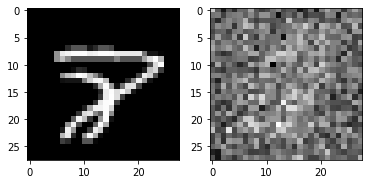

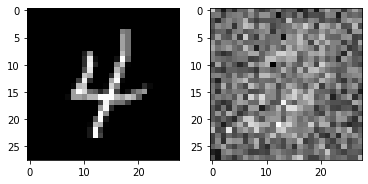

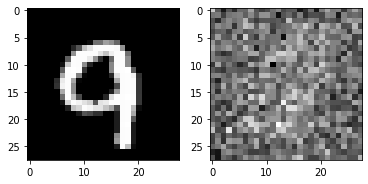

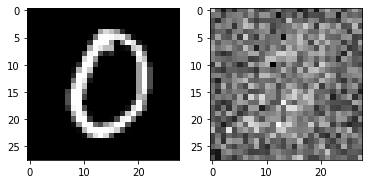

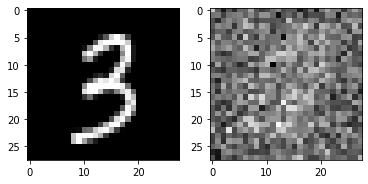

Validation loss: 1379719.8712180506
Validation loss: 1204809.552710822
Validation loss: 1098741.6144933042
Validation loss: 1019099.5075349686
Starting epoch:  1
Validation loss: 967670.9596202363
Validation loss: 937134.0474998079
Validation loss: 905094.4074556803
Validation loss: 888597.8054652573
Validation loss: 871080.1665216545
Starting epoch:  2
Validation loss: 857550.6782439771


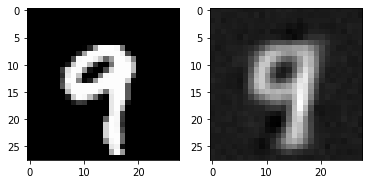

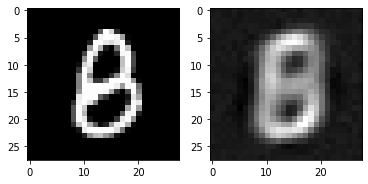

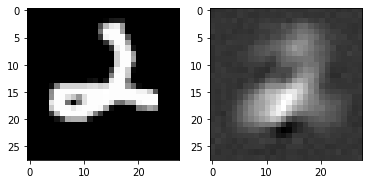

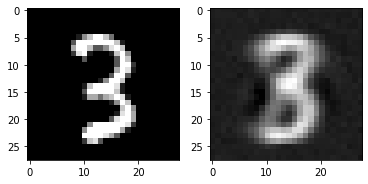

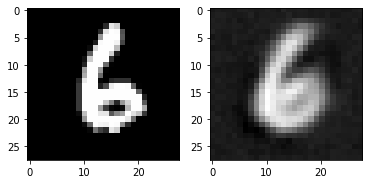

Validation loss: 844369.476022208
Validation loss: 831761.1309003994
Validation loss: 821677.7127206445
Validation loss: 816301.6844473687
Starting epoch:  3
Validation loss: 808805.6298788121
Validation loss: 802565.0045222414
Validation loss: 797820.1254816754
Validation loss: 793070.6971106699
Validation loss: 788006.8867561936
Starting epoch:  4
Validation loss: 782152.3206529119


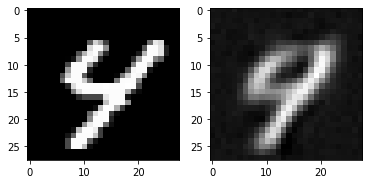

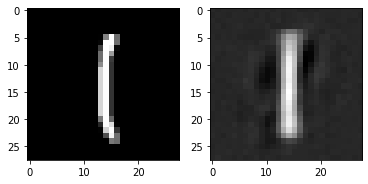

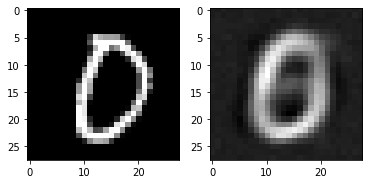

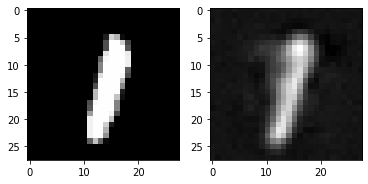

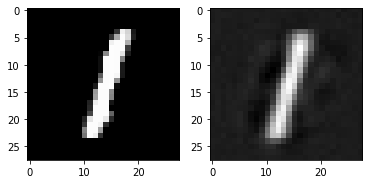

Validation loss: 778235.8705305691
Validation loss: 773595.7722389448
Validation loss: 770322.525378991
Validation loss: 767156.9744229292
Starting epoch:  5
Validation loss: 762732.7692437271
Validation loss: 764017.8398387246
Validation loss: 758396.6829968817
Validation loss: 758367.2410905898
Validation loss: 752664.747728213
Starting epoch:  6
Validation loss: 749246.3808945161


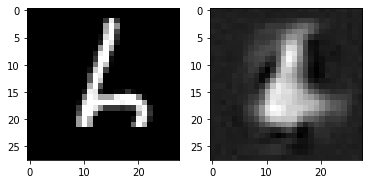

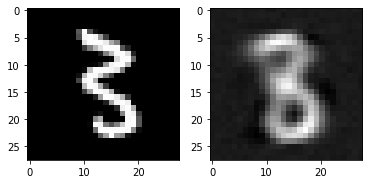

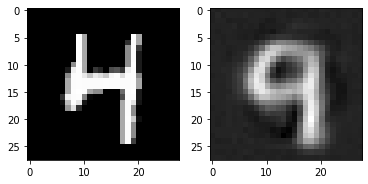

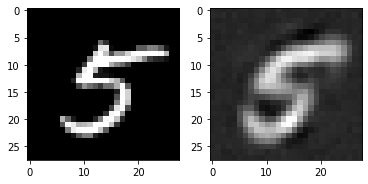

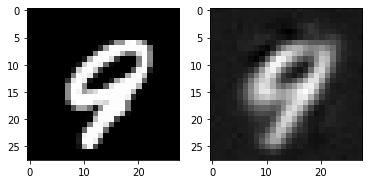

Validation loss: 751136.1162129937
Validation loss: 746028.1636528303
Validation loss: 745685.4822713454
Validation loss: 745306.1392934782
Starting epoch:  7
Validation loss: 740099.5807672982
Validation loss: 740423.3835338071
Validation loss: 738741.6867521013
Validation loss: 738025.3429994643
Validation loss: 737674.6696224217
Starting epoch:  8
Validation loss: 735201.2406138283


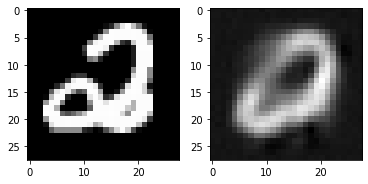

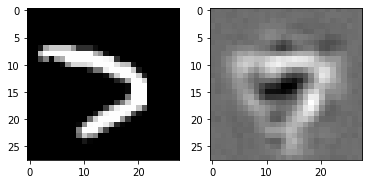

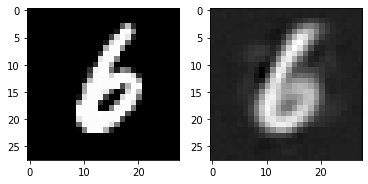

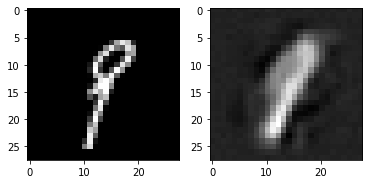

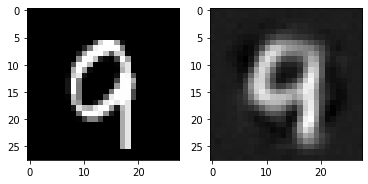

Validation loss: 733558.4872116892
Validation loss: 735146.6539048519
Validation loss: 733036.0771501701
Validation loss: 731924.551650729
Starting epoch:  9
Validation loss: 728225.5252629408
Validation loss: 731077.4674768792
Validation loss: 728746.4008022342
Validation loss: 725840.1707510703
Validation loss: 727224.7695950702
Starting epoch:  10
Validation loss: 722662.3878305122


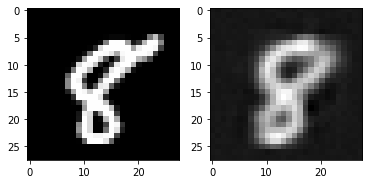

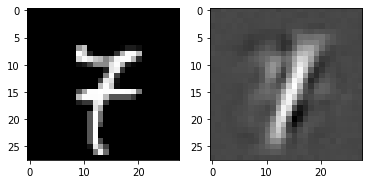

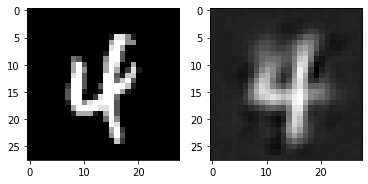

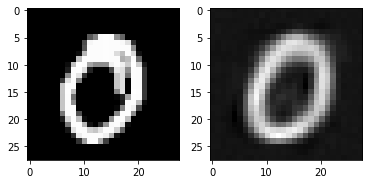

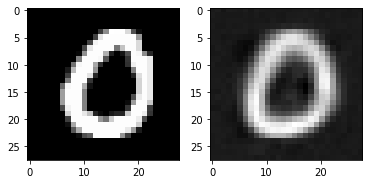

Validation loss: 725344.895779362
Validation loss: 727529.8249868859
Validation loss: 723272.2848095299
Validation loss: 721887.2771972922
Starting epoch:  11
Validation loss: 717710.9232869868
Validation loss: 722383.5408562279
Validation loss: 721189.6691317437
Validation loss: 720782.7386801582
Validation loss: 719702.5515454646
Starting epoch:  12
Validation loss: 714409.2714360399


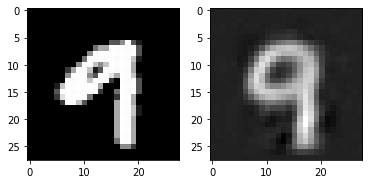

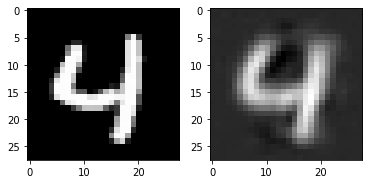

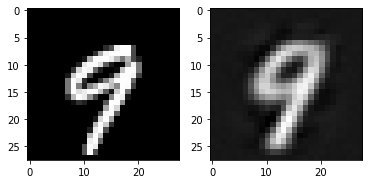

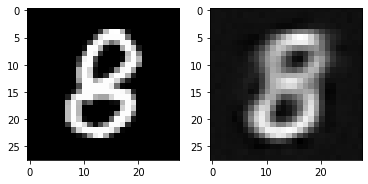

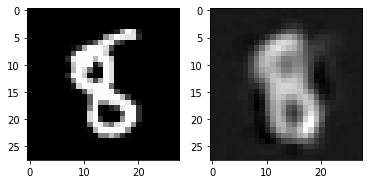

Validation loss: 719248.1925571791
Validation loss: 718890.6864077196
Validation loss: 716560.0918960663
Validation loss: 717629.6079953267
Starting epoch:  13
Validation loss: 710631.4683974881
Validation loss: 716557.5982908901
Validation loss: 717261.9466319155
Validation loss: 715568.3241573345
Validation loss: 716092.3738063314
Starting epoch:  14
Validation loss: 709823.9721685058


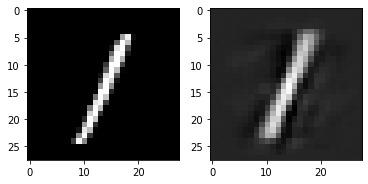

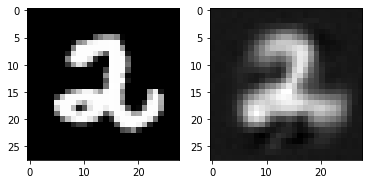

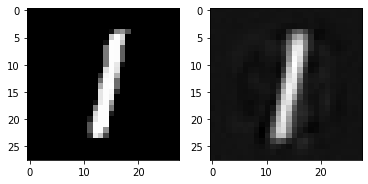

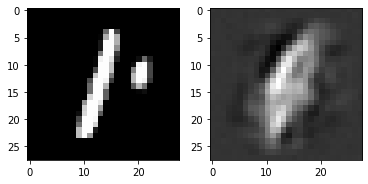

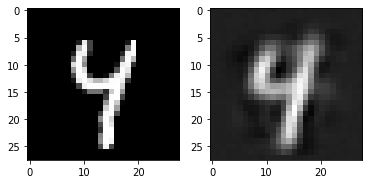

Validation loss: 714008.8639257572
Validation loss: 713369.7815481548
Validation loss: 713041.5194634377
Validation loss: 713001.393225588
Starting epoch:  15
Validation loss: 707519.3189480874
Validation loss: 712663.3023566483
Validation loss: 711571.0786396326
Validation loss: 712571.6452345907
Validation loss: 712124.8911204968
Starting epoch:  16
Validation loss: 707135.2910005079


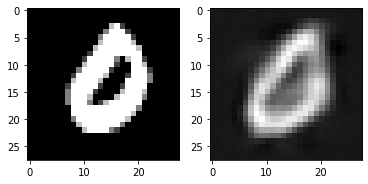

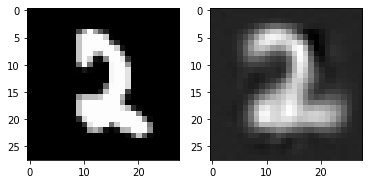

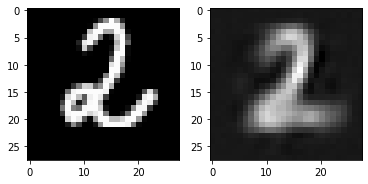

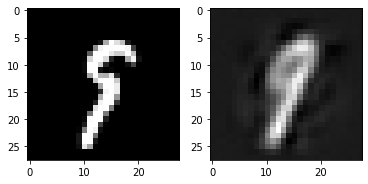

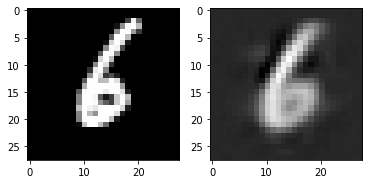

Validation loss: 711366.1328093142
Validation loss: 710330.018473084
Validation loss: 712050.5831926758
Validation loss: 710724.1076206003
Starting epoch:  17
Validation loss: 704843.372634396
Validation loss: 709214.8259305211
Validation loss: 712394.611820549
Validation loss: 709779.173505731
Validation loss: 707838.5299882827
Starting epoch:  18
Validation loss: 703140.4392838673


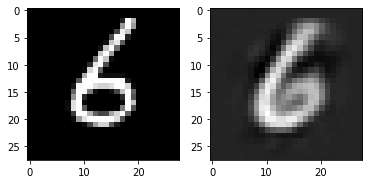

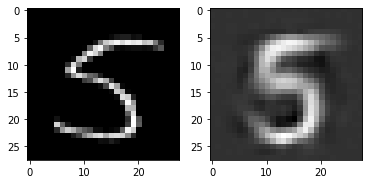

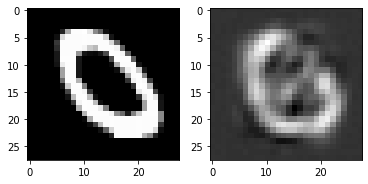

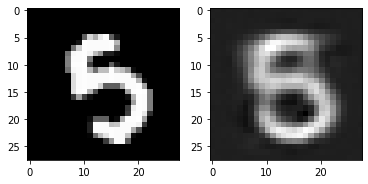

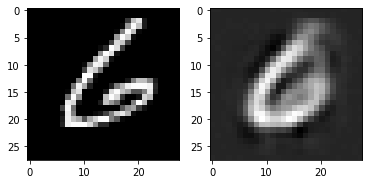

Validation loss: 708732.5796451672
Validation loss: 711368.7805365688
Validation loss: 707464.8514830708
Validation loss: 708670.5831125783
Starting epoch:  19
Validation loss: 703259.3733372382
Validation loss: 708278.4053427473
Validation loss: 711878.5354392611
Validation loss: 706622.4166722532
Validation loss: 708667.9288577564
Starting epoch:  20
Validation loss: 702414.2526700336


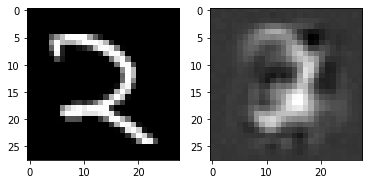

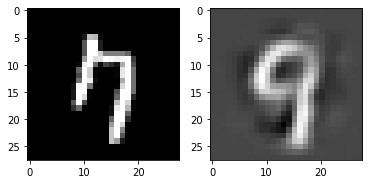

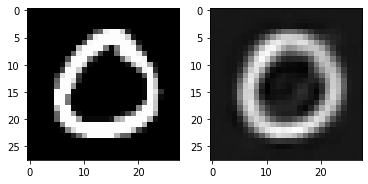

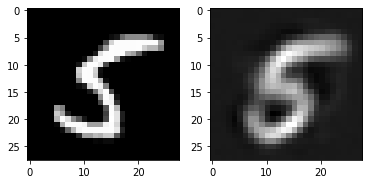

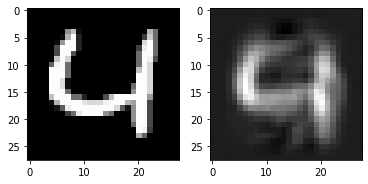

Validation loss: 707527.4024049902
Validation loss: 709285.9462712711
Validation loss: 708622.3871451304
Validation loss: 707307.3477612986
Starting epoch:  21
Validation loss: 701684.2259185311
Validation loss: 707948.2943766661
Validation loss: 709474.152456161
Validation loss: 705690.3487413304
Validation loss: 706369.4847759476
Starting epoch:  22
Validation loss: 701710.1740981303


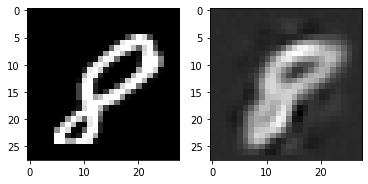

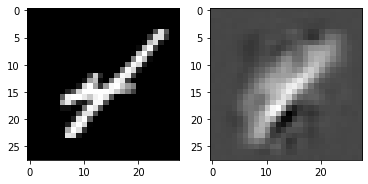

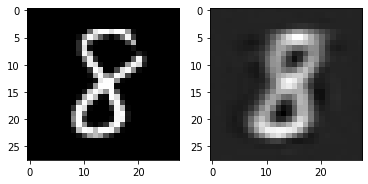

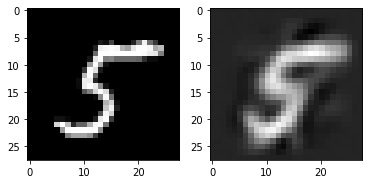

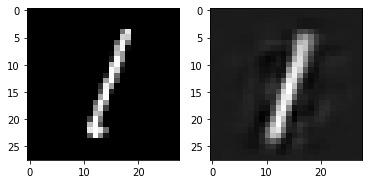

Validation loss: 707107.702070725
Validation loss: 706906.3832334396
Validation loss: 706685.2681878731
Validation loss: 704014.2214073491
Starting epoch:  23
Validation loss: 701131.3482131535
Validation loss: 707784.4597637911
Validation loss: 707293.1189847217
Validation loss: 706567.4138373982
Validation loss: 703849.3750277264
Starting epoch:  24
Validation loss: 701501.9924635139


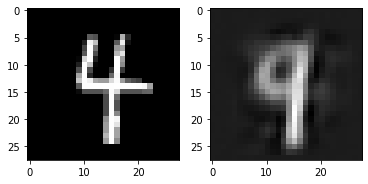

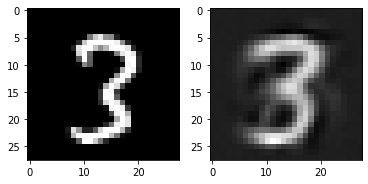

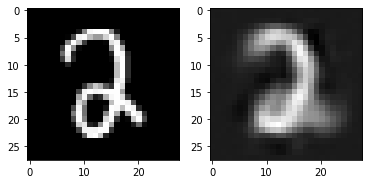

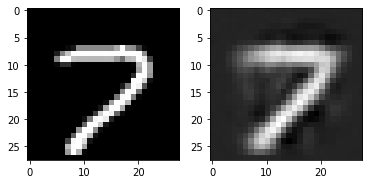

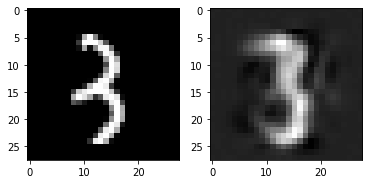

Validation loss: 706980.9339637012
Validation loss: 704638.8361227561
Validation loss: 707922.1547952268
Validation loss: 703395.3981633455
Starting epoch:  25
Validation loss: 701317.732438664
Validation loss: 708271.3985320167
Validation loss: 702388.31988567
Validation loss: 703205.7172797791
Validation loss: 704110.4863913753
Starting epoch:  26
Validation loss: 700648.3841711347


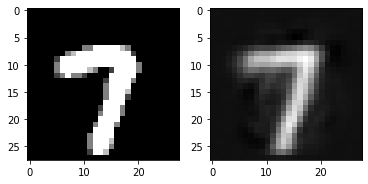

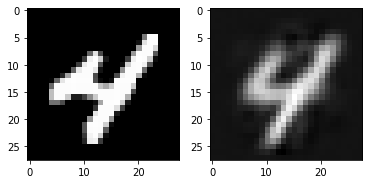

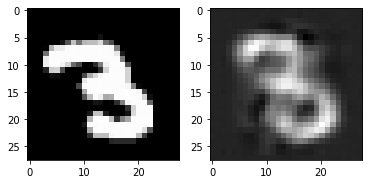

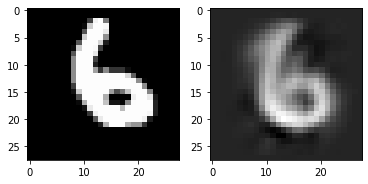

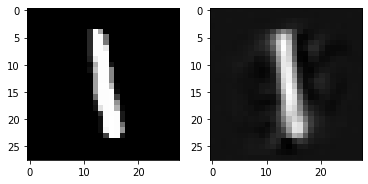

Validation loss: 705625.2820254947
Validation loss: 703576.1995601401
Validation loss: 704570.0454096718
Validation loss: 700050.2946500643
Starting epoch:  27
Validation loss: 699335.4338624005
Validation loss: 704997.2548739376
Validation loss: 703146.8063795392
Validation loss: 705848.9501440673
Validation loss: 701276.8321963792
Starting epoch:  28
Validation loss: 699515.0392846215


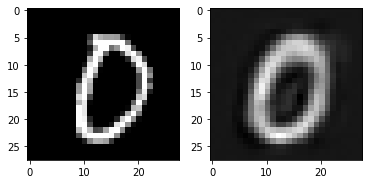

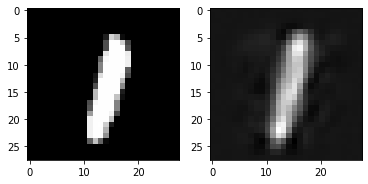

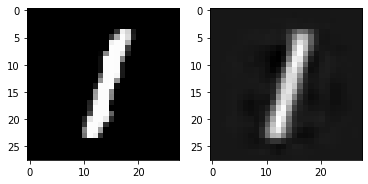

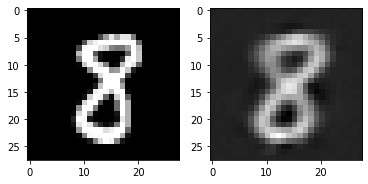

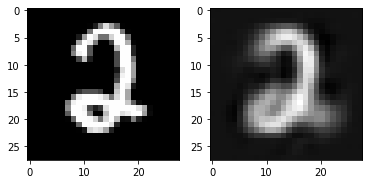

Validation loss: 705545.4452962872
Validation loss: 701298.7073014874
Validation loss: 706449.5679946597
Validation loss: 701531.7857655345
Starting epoch:  29
Validation loss: 697350.1408304629
Validation loss: 705624.343179389
Validation loss: 700447.4415864402
Validation loss: 702683.2191122958
Validation loss: 700804.7766825459


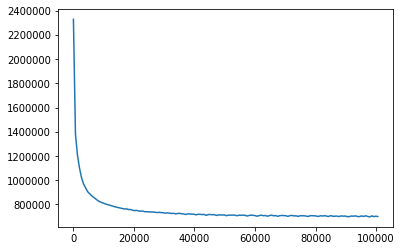

In [8]:
encode = EncodeModel([785,100,50,5], False, True)
decode = DecodeModel([5,50, 100, 785],False, True)
val_loss = train_mnist(encode, decode, 30)
utils.plot_loss(val_loss, "Validation loss")

## Sampling
Sampling is not really possible in the simple auto encoder as it is not stochastic in nature. The see the notebook on variational auto encoder instead.